# SQLExecutor PoC Project

This project aims to develop an extensible solution that integrates Natural Language Processing (NLP) with database query execution to provide seamless natural language-to-SQL transformation. The SQLExecutor is designed to function as a backend for chatbots or other applications requiring dynamic query generation.

The focus of the PoC is support for **SELECT** queries.

# Objectives and Key Features- **Natural Language Querying:** Translate user input into valid SQL queries to make database interaction simple and intuitive.
- **Database-Agnostic Design:** Support multiple SQL flavors and databases with schema-based configurations.
- **Schema-Driven Approach:** Operates based on user-provided schemas, ensuring flexibility and adaptability across use cases.
- **Secure and Configurable:** Implements granular security controls to restrict access to tables, columns, and query types.
- **Basic Context Awareness Using JWT:** Leverages JWT tokens to enforce user-specific access controls by dynamically resolving attributes like `user_id` or `role`. This enables secure, personalized data access without requiring users to explicitly define their context.
- **Extensible Architecture:** Allows easy integration of new schemas, databases, and configurations to scale with user needs.eeds.


# Process Workflows and Use Cases

There are three actors in the SQL Executor:

1. User - The person who has initiated the Prompt.
2. The System - The backend of the SQL Executor, it handles security, NLP Enrichment, and executing the SQL command that is generated by the NLP.
3. The NLP Model - Resolves Natural Languages that outputs cohherrent values that the System can understand.

## User Setup

These Workflow Diagrams explains the processes that are needed in-order to setup the SQL Executor to read and use your schemas in generating SQL Statements and executing them.

### Loading the Schema to the SQLExecutor

This is a necessary first step as the schemas must be loaded into the SQLExecutor to be read and used when generating content. There are two ways to load a schema: 

1. **Schema as a File:** A templated and formatted file provided by the user to the SQLExecutor. 
2. **Database Introspection:** The SQLExecutor connects directly to the database and uses `INFORMATION_SCHEMA` queries to read the tables and schema.

The latter approach will not be explored in this PoC and is considered an enhancement. However, a possible workflow for it will still be prov

The schema will be read by the SQL Executor, and each schema must be stored in a separate file in JSON format. The columns include description fields to help the AI understand the purpose of each field. Descriptions should be concise yet detailed, providing a brief explanation of the column's function.

Some features are not included on this PoC but setup as an enchancement.

1. Setting up Multiple Rulesets Files e.g:
```json
"filter_rules": ["${filter_rules_orders}", "${another_ruleset}"]
```
2. Execution of other queries aside from **SELECT** e.g (UPDATE, DELETE, INSERT)ided.

**Schema Fields**

| **Field**       | **Description**                                                                                       |
|------------------|-------------------------------------------------------------------------------------------------------|
| `schema_name`    | The name of the schema to be read by the SQL Executor.                                                |
| `description`    | A brief explanation of the schema's purpose. This should provide a clear understanding of the field's role. Table description is mandatory, optional for columns|
| `tables`         | Contains table definitions, including columns, their types, descriptions, constraints, and restrictions. |
| `restrictions`   | Includes filter rules, which are interpolated rulesets that can be defined in the rules directory.    
| `synonyms`       | (Optional) A list of alternative names or keywords associated with the table or column to assist NLP models in identifying user intent.    |

```json
{
  "schema_name": "ecommerce",
  "description": "Schema for e-commerce platform data management",
  "filter_rules": ["${ecommerce_ruleset}"],  // Schema-wide rules
  "tables": {
    "users": {
      "description": "Stores user account information",
      "synonyms": ["customers", "accounts"],
      "columns": {
        "user_id": { 
          "type": "INTEGER"
          "constraints": ["PRIMARY KEY", "NOT NULL"] 
        },
        "name": { 
          "type": "TEXT", 
          "description": "Full name of the user",
          "constraints": ["NOT NULL"] 
        },
        "email": { 
          "type": "TEXT"
          "constraints": ["UNIQUE", "NOT NULL"] 
        }
      }
    },
    "orders": {
      "description": "Stores order details",
      "columns": {
        "order_id": { 
          "type": "INTEGER", 
          "description": "Unique identifier for each order", 
          "constraints": ["PRIMARY KEY", "NOT NULL"] 
        },
        "user_id": { 
          "type": "INTEGER", 
          "description": "References the user placing the order", 
          "constraints": ["FOREIGN KEY"], 
          "references": { "table": "users", "column": "user_id" }
        },
        "amount": { 
          "type": "DECIMAL", 
          "description": "Total order amount", 
          "constraints": ["NOT NULL"] 
        }
      },
      "relationships": {
        "joins": [
          {
            "table": "users",
            "on": "orders.user_id = users.id",
            "type": "INNER",
            "description": "Each order is placed by a user."
          }
        ]
      }
    }
  }
}
```

**Notes**:

1. Setting descriptions or synonnyms in each columns **is not recommended**, these descriptions are for column names that are not descriptive or need additional context when NLP models read it.
2. Make the column name as descriptive as possible so the NLP model can infer it easily.

---
**Ruleset**

The ruleset is a separate file from the schema field. Ruleset values are found in the `filter_rules` field. For example, if you have a ruleset JSON file named `filter_rules_orders.json`, it is interpolated in the `filter_rules` field as follows:

```json
"filter_rules": "['${filter_rules_orders}']"
```

| **Field**           | **Description**                                                                                           |
|----------------------|-----------------------------------------------------------------------------------------------------------|
| `ruleset_name`       | The name of the ruleset file, which should be unique and descriptive to identify its purpose.             |
| `description`        | A brief explanation of the ruleset’s purpose, providing context for its role in access control.           |
| `default_policy`     | The default action (`allow` or `deny`) applied if no specific rules match a request.                      |
| `global_rules`       | High-level rules that apply universally across all tables and users unless overridden by more specific rules. |
| `table_rules`        | Rules specific to individual tables, including allowed/denied columns and access conditions.              |
| `user_specific_rules`| Overrides or additional rules for individual users or groups, taking precedence over global and table rules.|
| `columns`            | Specifies which columns are allowed or denied access for each rule (`allow` supports wildcards like `*`). |
| `condition`          | A condition (e.g., SQL-like logic) that defines when the rule applies, such as role-based or user-specific constraints. |


**JWT Integration with the Ruleset**

The ruleset uses **JWT claims** (e.g., `user_id`, `role`, or `email`) to enforce **dynamic, context-aware security policies**. Placeholders like `${jwt.user_id}` or `${jwt.role}` are used in the ruleset conditions and dynamically resolved by the system during query validation.

Example JWT-based context in ruleset:
```json
{
  "condition": "role = 'admin' OR user_id = ${jwt.user_id}"
}
```

The system ensures that the resolved values from the JWT token are valid, authenticated, and applied securely to restrict access based on the user’s identity and role.


**Sample Ruleset**

```json
{
  "ruleset_name": "ecommerce_ruleset",
  "description": "Ruleset for managing access to the e-commerce schema with JWT-based user context",
  "default_policy": "deny",
  "global_rules": {
    "columns": {
      "allow": "*",
      "deny": ["password"]  // Sensitive fields universally denied
    },
    "condition": "TRUE"  // Applies to all roles unless specified
  },
  "table_rules": {
    "users": {
      "columns": {
        "allow": ["user_id", "name", "email"],
        "deny": ["password"]
      },
      "condition": "users.user_id = ${jwt.user_id}"  // Restrict access to rows matching the user's ID from the JWT
    },
    "orders": {
      "columns": {
        "allow": ["order_id", "amount", "user_id"],
        "deny": ["status"]
      },
      "condition": "orders.user_id = ${jwt.user_id} OR ${jwt.role} = 'admin'"  // Allow access to user's own orders or for admins
    }
  },
  "user_specific_rules": [
    {
      "user": "specific_user@example.com",
      "columns": {
        "allow": ["id", "email"],
        "deny": []
      },
      "condition": "T---RUE"  // This user bypasses table-specific conditions
    }
  ]
}
```



**How the Ruleset Works**

1. **JWT Integration**:
   - The ruleset includes placeholders (e.g., `${jwt.user_id}`) to dynamically enforce user-specific and role-based constraints.
   - JWT tokens are validated by the system to extract claims such as `user_id` and `role`.

2. **Dynamic Resolution**:
   - During query processing, the system replaces placeholders in the ruleset with actual values from the JWT token.
   - Example: `user_id = ${jwt.user_id}` becomes `user_id = 123`.

3. **Hierarchical Evaluation**:
   - The ruleset resolves access permissions by merging global rules, table-specific rules, and user-specific overrides.
   - Higher-priority rules (e.g., user-specific) override lower-priority rules (e.g., global rules).


**Example 1: Querying User’s Email**
**User Query**:
> "Can you get me my email?"

**JWT Claims**:
```json
{
  "user_id": 123,
  "email": "specific_user@example.com",
  "role": "user"
}
```

**Resolved Ruleset**:
```json
{
  "allowed_columns": ["user_id", "name", "email"],
  "denied_columns": ["password"],
  "condition": "users.user_id = 123"
}
```


**Example 2: Admin Accessing All Orders**
**User Query**:
> "Show me all order amounts"

**JWT Claims**:
```json
{
  "user_id": 456,
  "email": "admin_user@example.com",
  "role": "admin"
}
```

**Resolved Ruleset**:
```json
{
  "allowed_columns": ["order_id", "amount", "user_id"],
  "denied_columns": ["status"],
  "condition": "TRUE"
}
```

##### Workflow Diagram on Setting up the SQL Schema
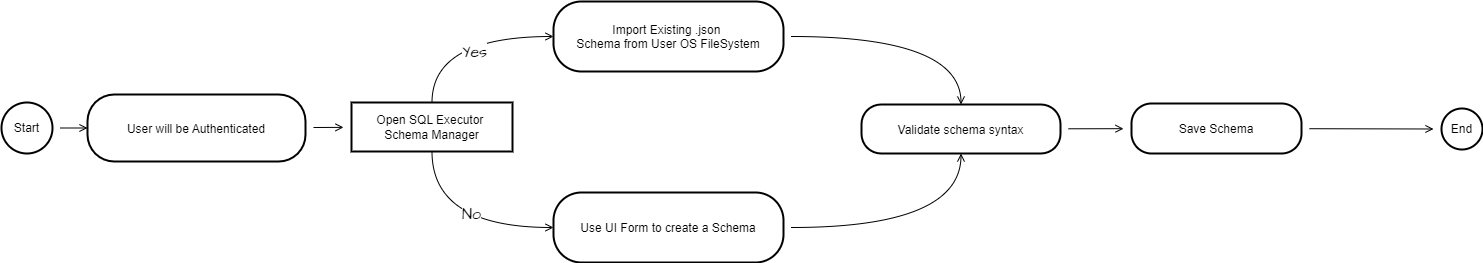

### JWT Attribute Not Found in User's JWT Claim

In cases where a required JWT attribute is missing from the user's JWT claim but is referenced in the schema, the request will be blocked. An error message will be returned, informing the user that a required JWT attribute is missing.

##### Workflow Diagram: JWT Attribute Missing

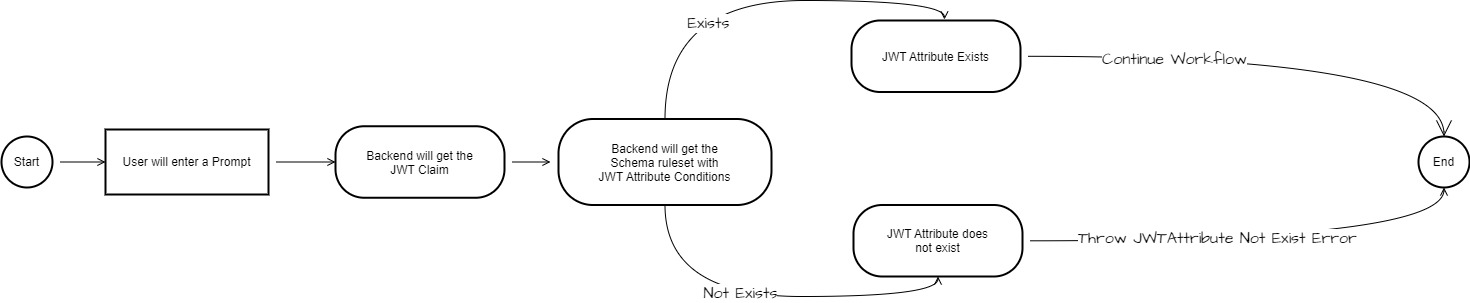

## The Resolved Prompt and Query Scope Object

The process of the SQL Executor is a combination of the NLP Prompting and System Manipulation. The System first ensure that the User that it is requesting to trigger a SQL Operation via prompt must have access to the data. With that, the System uses the rulesets to check if User has authorization. 

In-order to get that we first get the **scope** of the request of the User. Not only we use this scope object for Authorization, we also use it for Schema mapping where we find what is the appropriate schema to be used on the request. 

Finally after we have verified it, the System will create an formatized Prompt together with the conformed table fields on the Schema. And then we will print out the SQL where the System will use that SQL to trigger a request. 

### Defining the query_scope Object

The SQL Executor System requires identifying the **query_scope** of the user's input based on natural language. While it is challenging for the system to determine the exact scope of the query alone, combining it with an NLP model allows for extracting the necessary context from the user's prompt. To standardize this process, the NLP model outputs a structured JSON object in a predefined format, enabling the system to interpret and process the query efficiently.

The **query_scope** object focuses on identifying the **tables** and **columns** mentioned in the user's query, which the system then validates against available schemas and rulesets. This PoC and project currently only supports **SELECT** operations.


**Query Scope Fields**

| **Field**         | **Strategy**                                                                                             |
|--------------------|---------------------------------------------------------------------------------------------------------|
| `intent`           | **Mandatory**: The core driver of SQL generation. Must always be included by NLP. Static and predefined. |
| `entities`         | **Mandatory**: Includes the tables and columns referenced in the query.                                 |
| `entities.tables`  | **Mandatory**: At least one table is required to validate and resolve the query.                        |
| `entities.columns` | **Optional**: Include if specific columns are referenced in the query; use `["*"]` if all columns apply. |


**Intent Mapping**

Below are the supported `intent` values and their corresponding SQL operations. For this PoC, only `fetch_data` is supported.

| **Intent**      | **SQL Operation** | **Description**                                                                 |
|------------------|-------------------|---------------------------------------------------------------------------------|
| `fetch_data`     | `SELECT`          | Retrieve data from the database based on user-specified conditions.             |
| `update_data`    | `UPDATE`          | Modify existing data in the database.                                           |
| `delete_data`    | `DELETE`          | Remove data from the database.                                                  |
| `insert_data`    | `INSERT`          | Add new records to the database.                                                |
| `schema_info`    | `DESCRIBE`/`SHOW` | Retrieve schema details or metadata about tables and columns.                   |

**Example 1: Single Table Query**

**User Query**:
> "Show me my email in the users table"

**NLP Output**:
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["users"],
    "columns": ["email"]
  }
}
```

**Example 2: Multi-Table Query**

**User Query**:
> "Show me order amounts and customer names"

**NLP Output**:
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["orders", "users"],
    "columns": ["orders.amount", "users.name"]
  }
}
```

**Example 3: Ambiguous Query**

**User Query**:
> "Get me the details of all completed transactions"

**NLP Output**:
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["transactions"],
    "columns": ["*"]
  }
}
```

**Example 4: Query with Keywords**

**User Query**:
> "Get all orders placed last week"

**NLP Output**:
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["orders"],
    "columns": ["*"]
  }
}
```



**Query Scope Prompt Format**

You are an assistant that generates structured JSON `query_scope` objects for SQL queries. Based on the User Query, extract the key elements and structure them in the required format.

Instructions:
1. **Identify the purpose of the query** and assign the `intent`. Use one of the following:
   - `fetch_data` for SELECT operations.
   - `update_data` for UPDATE operations.
   - `delete_data` for DELETE operations.
   - `insert_data` for INSERT operations.
   - `schema_info` for DESCRIBE/SHOW operations.

2. **Extract the tables referenced** in the query:
   - Include the table names explicitly or implicitly mentioned in the query.
   - At least one table must be included in the `entities.tables` field.

3. **Extract the columns referenced** in the query:
   - Include column names if explicitly mentioned in the query.
   - If no specific columns are mentioned, use `["*"]` to indicate all columns.

4. Ensure the output adheres strictly to the Output Format below.

User Query:
{{user_query}}


Output Format:
```json
{
  "intent": "...", 
  "entities": {
    "tables": [...],
    "columns": [...]
  }
}

#### Workflow Diagram: Natural Language to Query Scope json
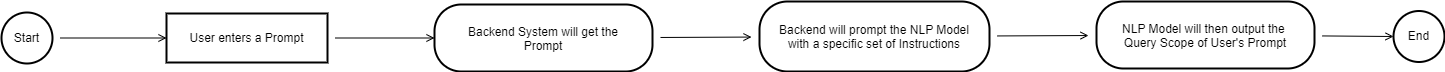



### Resolving the User Query into a Formatted Prompt

As outlined in the **rulesets** section, the system will interpolate values from the schema file to create a structured format. Only the **specified tables and columns** relevant to the query will be included in the prompt sent to the NLP model. To optimize token usage, fields that are not directly relevant (e.g., `schema_name`, `schema_description`, or `constraints` for `SELECT` queries) will be omitted.

Here’s an example workflow:

**`query_scope`:**

```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["users"],
    "columns": ["email"]
  }
}
```

**Resolved Schema:**

```json
{
  "filter_rules": {
    "allowed_columns": ["user_id", "name", "email"],
    "denied_columns": ["password"],
    "condition": "users.user_id = 123"
  },
  "tables": {
    "users": {
      "description": "Stores user account information",
      "synonyms": ["customers", "accounts"],
      "columns": {
        "user_id": {
          "type": "INTEGER",
          "description": "Unique identifier for each user",
          "constraints": ["PRIMARY KEY", "NOT NULL"]
        },
        "name": {
          "type": "TEXT",
          "description": "Full name of the user",
          "constraints": ["NOT NULL"]
        },
        "email": {
          "type": "TEXT",
          "description": "Email address of the user",
          "constraints": ["UNIQUE", "NOT NULL"]
        }
      }
    }
  }
}
```

**User Prompt:**

`"Show me my email in the users table"`


**Generated NLP Prompt:**

For `SELECT` operations, the schema is cleaned up to remove constraints and focus on essential details. The prompt sent to the NLP model will look like this:

```plaintext
You are an assistant that generates SQL queries based on user requests. Use the provided Schema to create a valid SQL query.

### Schema:
{
  "filter_rules": {
    "allowed_columns": ["user_id", "name", "email"],
    "denied_columns": ["password"],
    "condition": "users.user_id = 123"
  },
  "tables": {
    "users": {
      "description": "Stores user account information",
      "synonyms": ["customers", "accounts"],
      "columns": {
        "user_id": {
          "type": "INTEGER",
          "description": "Unique identifier for each user"
        },
        "name": {
          "type": "TEXT",
          "description": "Full name of the user"
        },
        "email": {
          "type": "TEXT",
          "description": "Email address of the user"
        }
      }
    }
  }
}

### Query:
"Show me my email in the users table"
```


**Explanation:**

1. **Filter Rules**:
   - The `allowed_columns` field restricts the query to permitted columns (`user_id`, `name`, and `email`).
   - The `denied_columns` ensures sensitive data like `password` is excluded.
   - The `condition` ensures row-level filtering is applied (`users.user_id = 123`).

2. **Schema Simplification**:
   - Non-essential fields like `constraints` are removed to reduce token usage while retaining column context.
   - Column `type` and `description` are included to assist the NLP model in understanding ambiguous column names.

3. **Query Focus**:
   - Only the `users` table and the `email` column are passed based on the `query_scope`.
   

**Another example of a Prompt**:

You are an assistant that generates SQL queries based on user requests. Use the provided Schema to create a valid SQL query.

```plaintext
### Schema:
{
  "filter_rules": {
    "allowed_columns": ["transaction_id", "user_id", "amount", "order_date"],
    "denied_columns": ["internal_notes"],
    "condition": "orders.user_id = 123"
  },
  "tables": {
    "orders": {
      "description": "Contains order-related information such as transactions and payments",
      "synonyms": ["transactions", "purchases"],
      "columns": {
        "transaction_id": {
          "type": "TEXT",
          "description": "A unique identifier for each transaction",
          "synonyms": ["txn_id", "order_reference"]
        },
        "user_id": {
          "type": "INTEGER",
          "description": "References the user who placed the order"
        },
        "amount": {
          "type": "DECIMAL",
          "description": "Total amount paid for the order",
          "synonyms": ["payment_total"]
        },
        "order_date": {
          "type": "DATE",
          "description": "The date when the order was placed"
        }
      }
    }
  }
}
```

Query:
"Show me the transactions and amounts for my orders"

**Explanation**

1. **Use of Descriptions and Synonyms**:
   - **Ambiguous Columns**:
     - `transaction_id` includes a description and synonyms (`txn_id`, `order_reference`) to clarify its purpose.
     - `amount` has a synonym (`payment_total`) to align with user-friendly terms.
   - **Self-Explanatory Columns**:
     - Columns like `user_id` and `order_date` only include descriptions and no synonyms since their names are already intuitive.

2. **Token Optimization**:
   - Only relevant tables, columns, and metadata (descriptions and synonyms) are included.
   - Non-relevant columns like `internal_notes` are excluded based on the `filter_rules`.

3. **Handling Synonyms**:
   - Synonyms are optional and only added when needed to map user-friendly terms or aliases to column names.

4. **Dynamic Adaptability**:
   - The schema adapts to ambiguous queries by leveraging synonyms and descriptions to align with user intent.

#### Workflow Diagram: Creating the Prompt
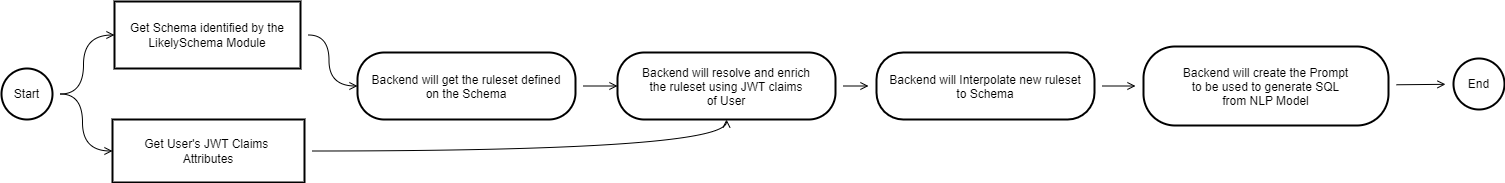

## Schema Lookup

Users can define multiple schemas as long as they follow the schema format enforced by the system. However, identifying the correct schema based on user prompts poses a challenge. Selecting the wrong schema may result in queries that do not meet user expectations. To address this, SQLExecutor offers two schema lookup approaches:

1. **NLP Lookup Approach**:  
   Utilizes the NLP model to infer the most relevant schema based on the user's input, supported by a scoring system to rank schemas by relevance.

2. **User-Specified Schema**:  
   Allows users to explicitly specify the schema to query, avoiding the need for inference and ensuring clarity.

Note that handling multiple schemas in a single query is not supported in the PoC but may be explored as a future enhancement.

### NLP Lookup Approach

The **NLP Lookup Approach** leverages the NLP model to infer the most relevant schema for a user's query. This approach is especially useful when users do not specify the schema explicitly, enabling the system to make an informed decision based on the query content. The lookup process involves several steps to ensure accuracy and user feedback.

Steps in the NLP Lookup Process:

1. **Initial Schema Matching**:  
   - The system evaluates all available schemas to check if any contain the table(s) referenced in the query.
   - If no matching schema is found, the system retries up to a maximum of **three attempts**, refining the query parsing each time.

2. **Handling Schema Not Found**:  
   - If no matching schema is found after three retries, the system informs the user:  
     _"The table or entity you are asking for does not exist in any schema."_

3. **Schema Scoring and Selection**:  
   - When multiple schemas match the query, the system uses a scoring mechanism to select the best fit. The scoring is based on the following criteria:

   | **Decision Criteria**                | **Description**                                                                                 | **Handled By**          | **Example**                                                                                   |
   |--------------------------------------|-------------------------------------------------------------------------------------------------|-------------------------|-----------------------------------------------------------------------------------------------|
   | **1. Table Presence**                | Does the schema contain the table(s) referenced in the query?                                  | **System**              | A schema with a `users` table matches better if the query references `users`.                |
   | **2. Column Relevance**              | Do the tables in the schema contain the columns referenced in the query?                       | **System**              | A schema with the `email` column in the `users` table scores higher if the query references it. |
   | **3. Schema Description Alignment**  | Does the schema’s description align with the query context? NLP analyzes descriptions to rank schemas. | **NLP Model**           | A schema with the description _"Stores user account information"_ aligns with _"Show my email."_ |

4. **Tiebreaker Handling**:  
   - If multiple schemas achieve the same score, the system will:
     - Inform the user: _"The query could not be resolved due to ambiguity between schemas."_  
     - This will be addressed as a future enhancement to handle schema conflicts more robustly.

5. **Saving the Query Scope**:  
   - Once the correct schema is identified, the system saves the `query_scope` (i.e., the tables and columns involved in the query) for use in subsequent query processing.

The **NLP Lookup Approach** ensures that the most relevant schema is selected while providing clear feedback to users when no matches or ambiguous results are encountered. This method balances automation with user guidance to maintain accuracy and user trust.

#### State Diagram: NLP Lookup Approach


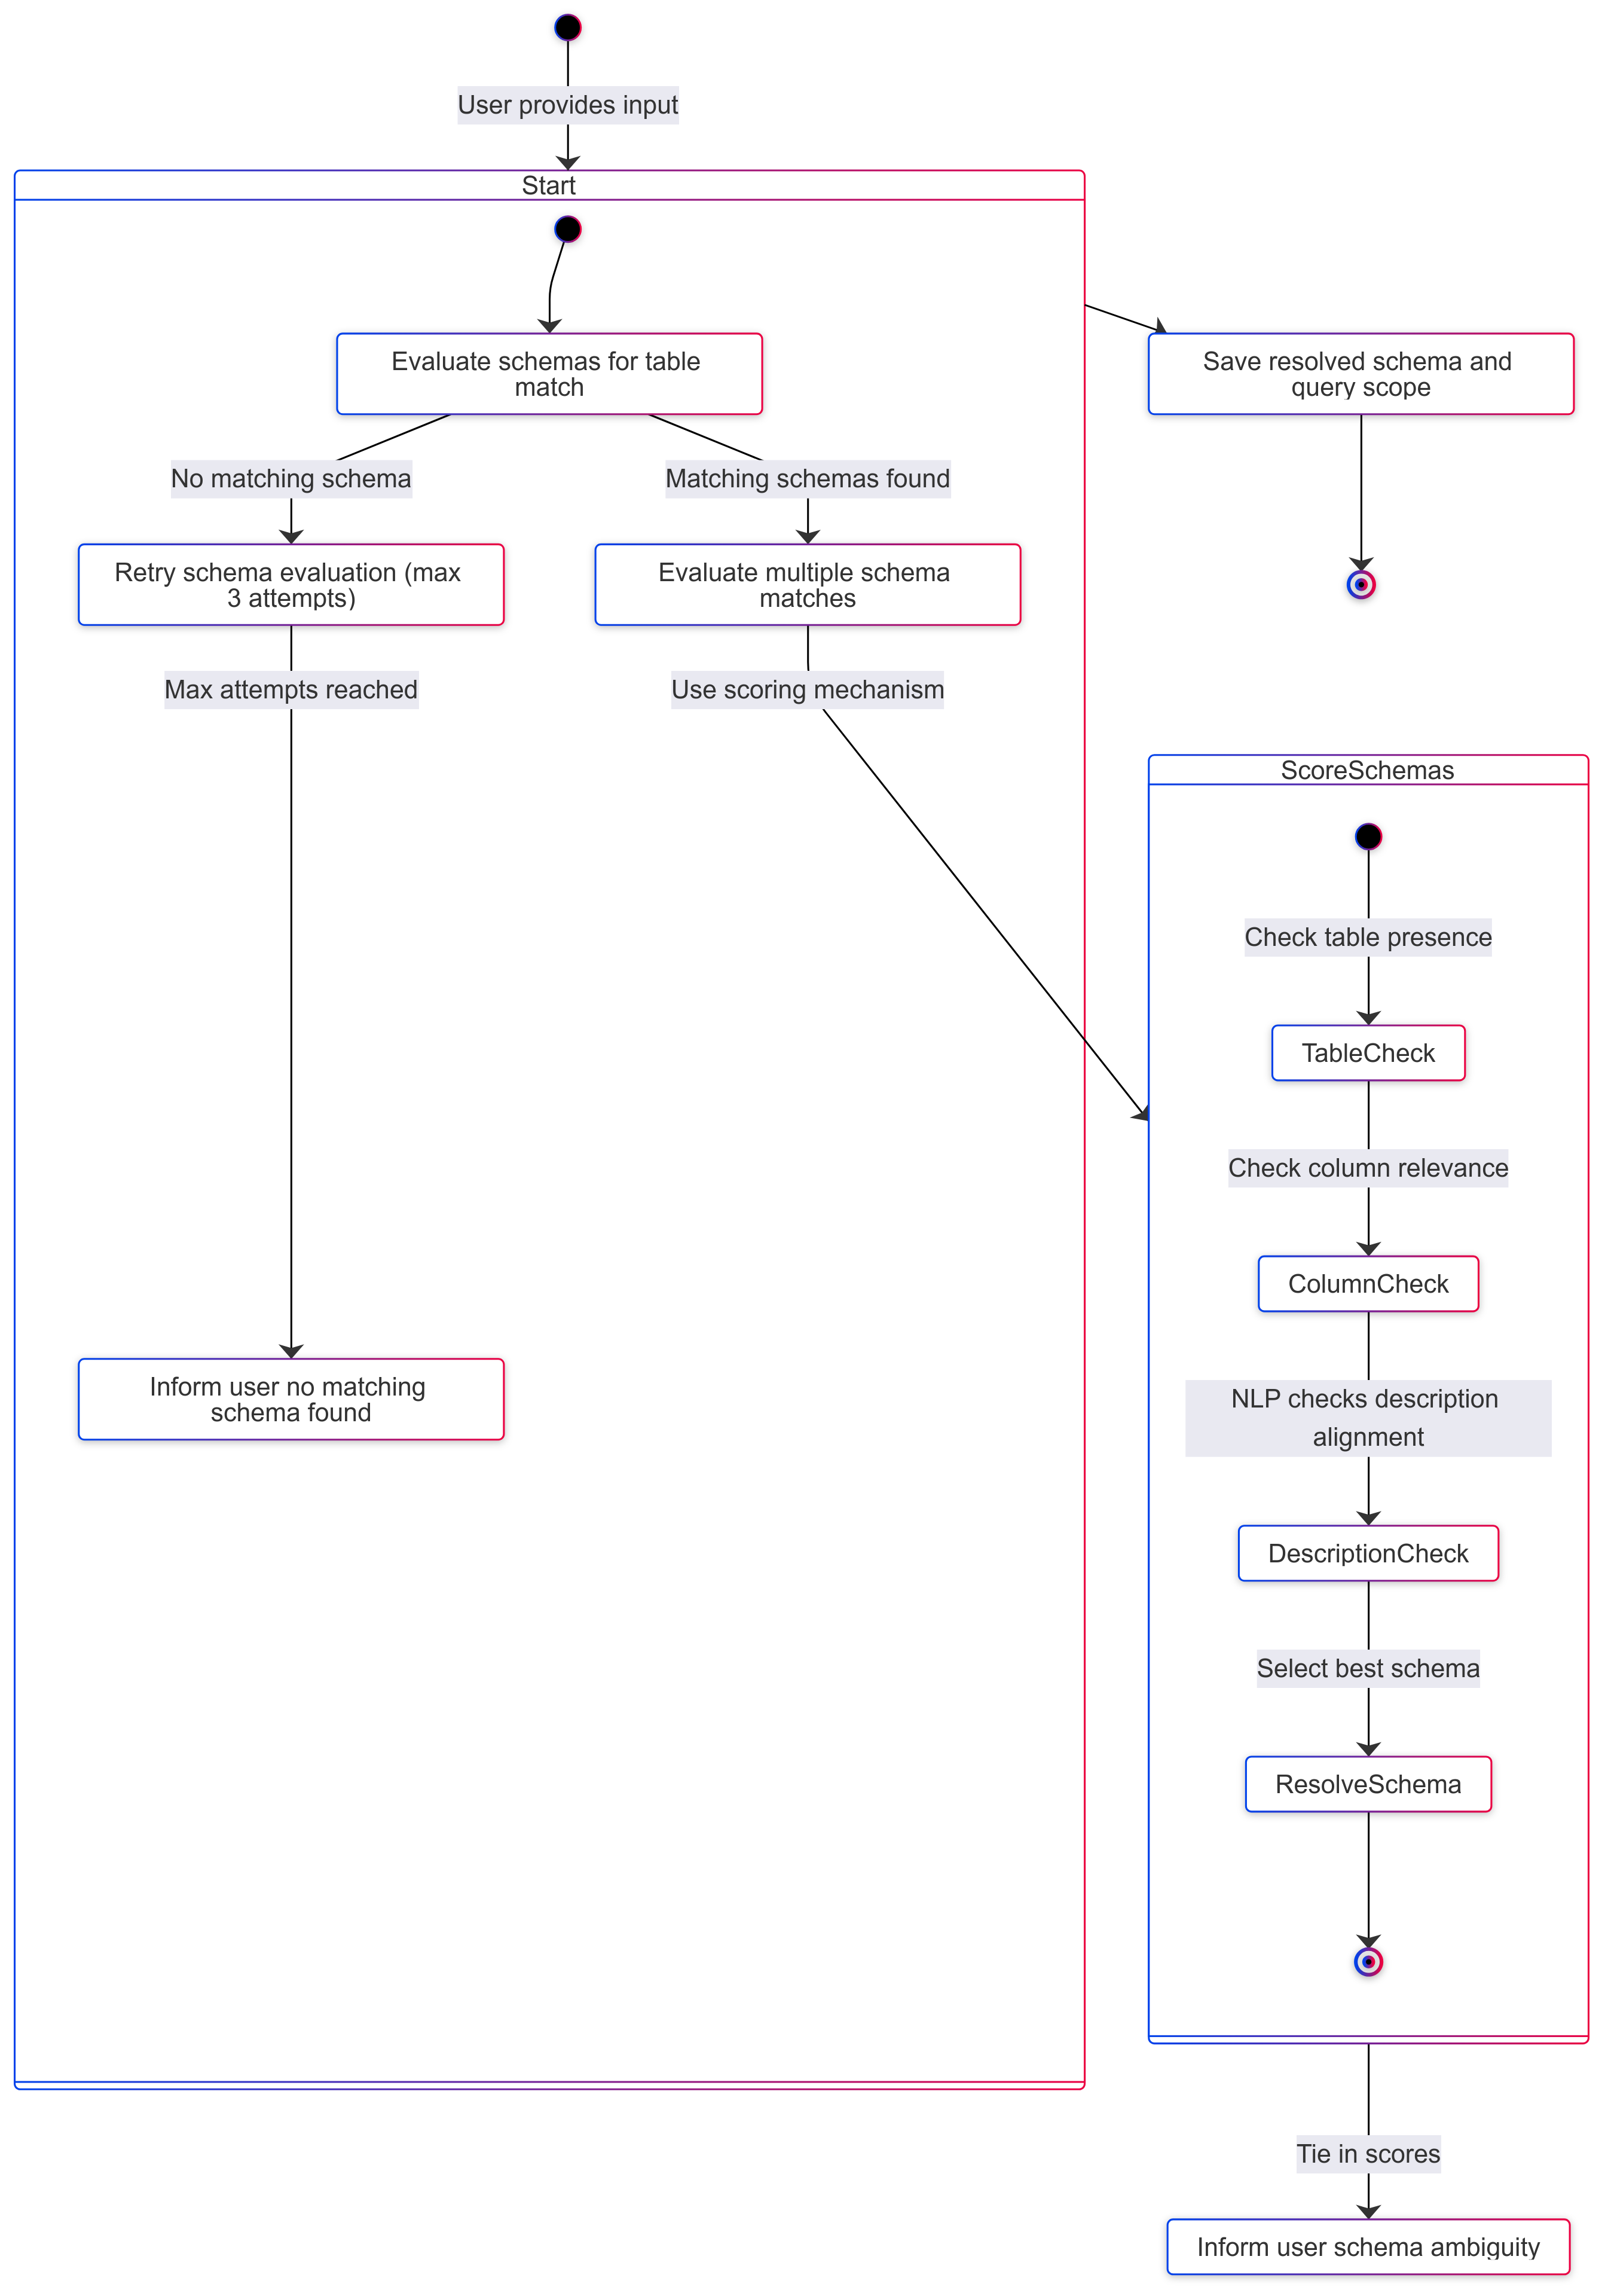

### User-Specified Schema

This is the simplest and fastest approach, as there is no need for SQLExecutor to perform schema lookup. However, please note that SQLExecutor will throw an error if it cannot find the specified column based on your prompt.

#### Workflow Diagram: User-Specified Schema

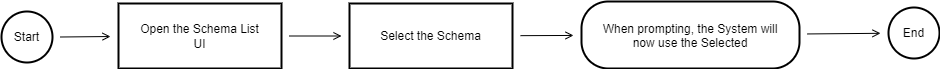

## User Authorization

SQLExecutor uses `JWT` claims for user authorization. In the future, additional authentication mechanisms like OpenSAML will be supported. 

The **login endpoint** at `'/sqlexecutor/api/login'` accepts a `POST` request to forward user credentials to an external authentication service. The external service must return a valid JWT with required attributes for authorization. Errors from the external service will also be forwarded to the user.

The **logout endpoint** at `'/sqlexecutor/api/logout'` calls the external service to terminate the user's session.

SQLExecutor’s login and logout endpoints act as wrappers for external authentication systems, making them extensible and adaptable.

**Example: Basic Login Request**

**Request**:
```http
POST /sqlexecutor/api/login
Content-Type: application/json

{
  "username": "user@example.com",
  "password": "securepassword"
}
```

**Response**:
```json
{
  "jwt": "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9...",
  "expires_in": 3600,
  "user_role": "admin"
}
```

**Example: Login with Additional Fields**

**Request**:
```http
POST /sqlexecutor/api/login
Content-Type: application/json

{
  "username": "user@example.com",
  "password": "securepassword",
  "organization_id": "12345",
  "two_factor_token": "abc123"
}
```

**Response**:
```json
{
  "jwt": "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9...",
  "expires_in": 3600,
  "user_role": "user",
  "organization_id": "12345"
}
```


### Workflow Diagram: User Authentication

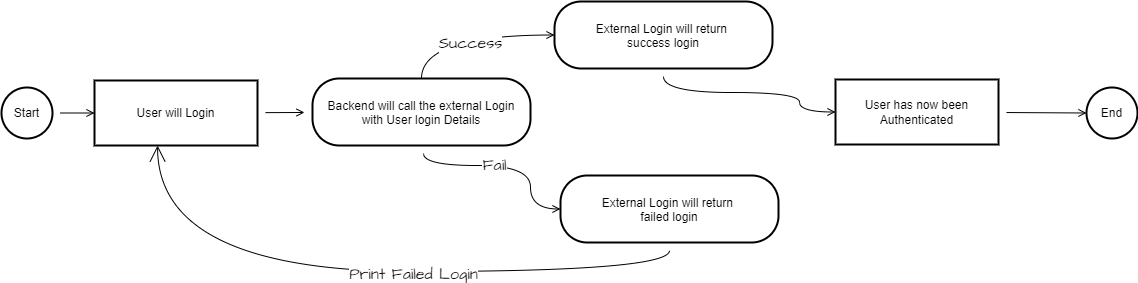

---
## Resolving User Authentication

To determine the level of access an authenticated user has to the requested data, the system uses `query_scope`, which identifies the columns and tables required for the query. This `query_scope` is then validated against the ruleset to ensure the user has the necessary permissions.

Consider the following example ruleset:

```json
{
  "ruleset_name": "ecommerce_ruleset",
  "description": "Ruleset for managing access to the e-commerce schema with JWT-based user context",
  "default_policy": "deny",
  "global_rules": {
    "columns": {
      "allow": "*",
      "deny": ["password"]  // Sensitive fields universally denied
    },
    "condition": "TRUE"  // Applies universally unless overridden
  },
  "table_rules": {
    "users": {
      "columns": {
        "allow": ["user_id", "name", "email"],
        "deny": ["password"]
      },
      "condition": "users.user_id = ${jwt.user_id}"  // Restrict access to rows matching the user's ID
    },
    "orders": {
      "columns": {
        "allow": ["order_id", "amount", "user_id"],
        "deny": ["status"]
      },
      "condition": "orders.user_id = ${jwt.user_id} OR ${jwt.role} = 'admin'"  // Allow user's orders or grant admin access
    }
  },
  "user_specific_rules": [
    {
      "user": "specific_user@example.com",
      "columns": {
        "allow": ["id", "email"],
        "deny": []
      },
      "condition": "TRUE"  // This user bypasses table-specific conditions
    }
  ]
}
```
**Example 1: Authorized Query**

**User Query**:
> "Show me my email in the users table"

**NLP Output**:
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["users"],
    "columns": ["email"]
  }
}
```

**JWT Claims**:
```json
{
  "user_id": 123,
  "role": "user",
  "email": "user@example.com"
}
```

**Result**:
The query passes all validation checks, and the user is granted access. The system proceeds with SQL query generation.

**Example 2: Unauthorized Query**

**User Query**:
> "Show me all user passwords in the users table"

**NLP Output**:
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["users"],
    "columns": ["password"]
  }
}
```

**JWT Claims**:
```json
{
  "user_id": 123,
  "role": "user",
  "email": "user@example.com"
}
```

**Result**:
The query fails validation due to access to the `password` column being denied. The system rejects the request and informs the user:  
*"Access denied: You do not have permission to query the 'password' column."*

**Example 3: Unauthorized Query (Non-Admin Request for All Data)**

**User Query**:  
> "Show me all the user data in the users table"

**NLP Output**:  
```json
{
  "intent": "fetch_data",
  "entities": {
    "tables": ["users"],
    "columns": ["*"]
  }
}
```

**JWT Claims**:  
```json
{
  "user_id": 123,
  "role": "user",
  "email": "user@example.com"
}
```

**Result**:  
The query fails validation because:
1. The wildcard `*` includes the denied `password` column.
2. The `users.user_id` condition restricts access to rows where `user_id = 123`, so the user cannot fetch all rows.

**System Response**:  
*"Access denied: You cannot retrieve all user data or query restricted fields."*


### Workflow Diagram: User Authorization

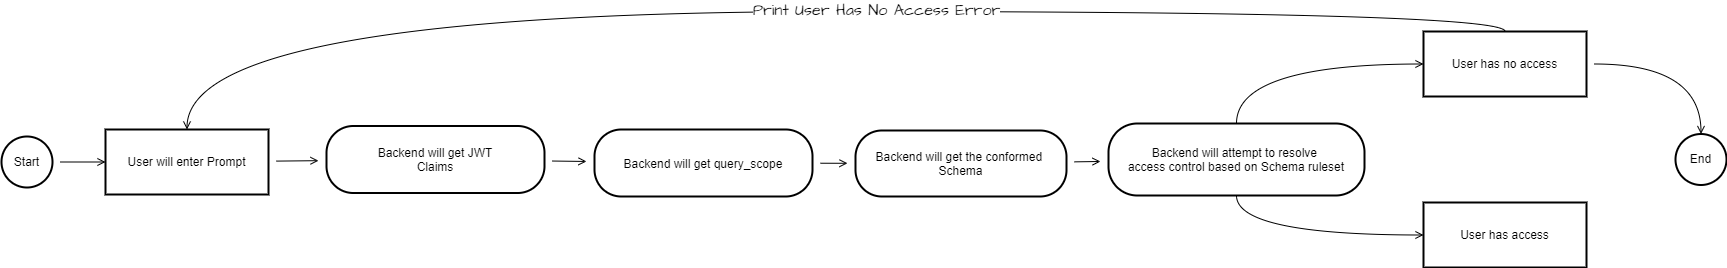

## Final Validation and Retry Mechanism

SQLExecutor validates the NLP-generated query to ensure it aligns with the user's request and adheres to the rules. Using `query_scope`, the system checks:

1. **Allowed Columns and Tables**: Confirms all columns and tables in the query are permitted.  
2. **Denied Columns**: Ensures no columns listed in `denied_columns` appear in the query.

If the query fails validation, SQLExecutor will prompt the NLP model to regenerate it. This process is repeated up to **three retries**. If the query remains invalid after three attempts, the system will stop and return an error:  
*"Unable to generate a valid query based on your request. Please refine your input and try again."*

### Workflow Diagram: Final Validation and Retry Mechanism

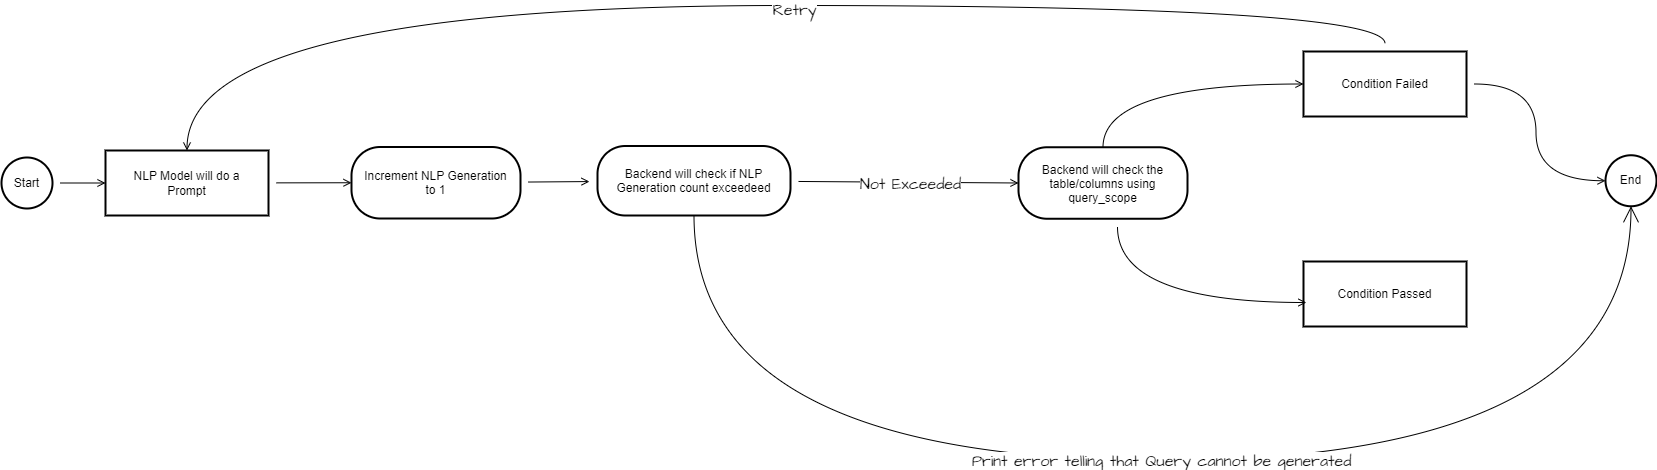

## The Complete Workflow

Below is a Flowchart containing the complete workflow of the SQLExecutor. 

### Flowchart: Complete Workflow


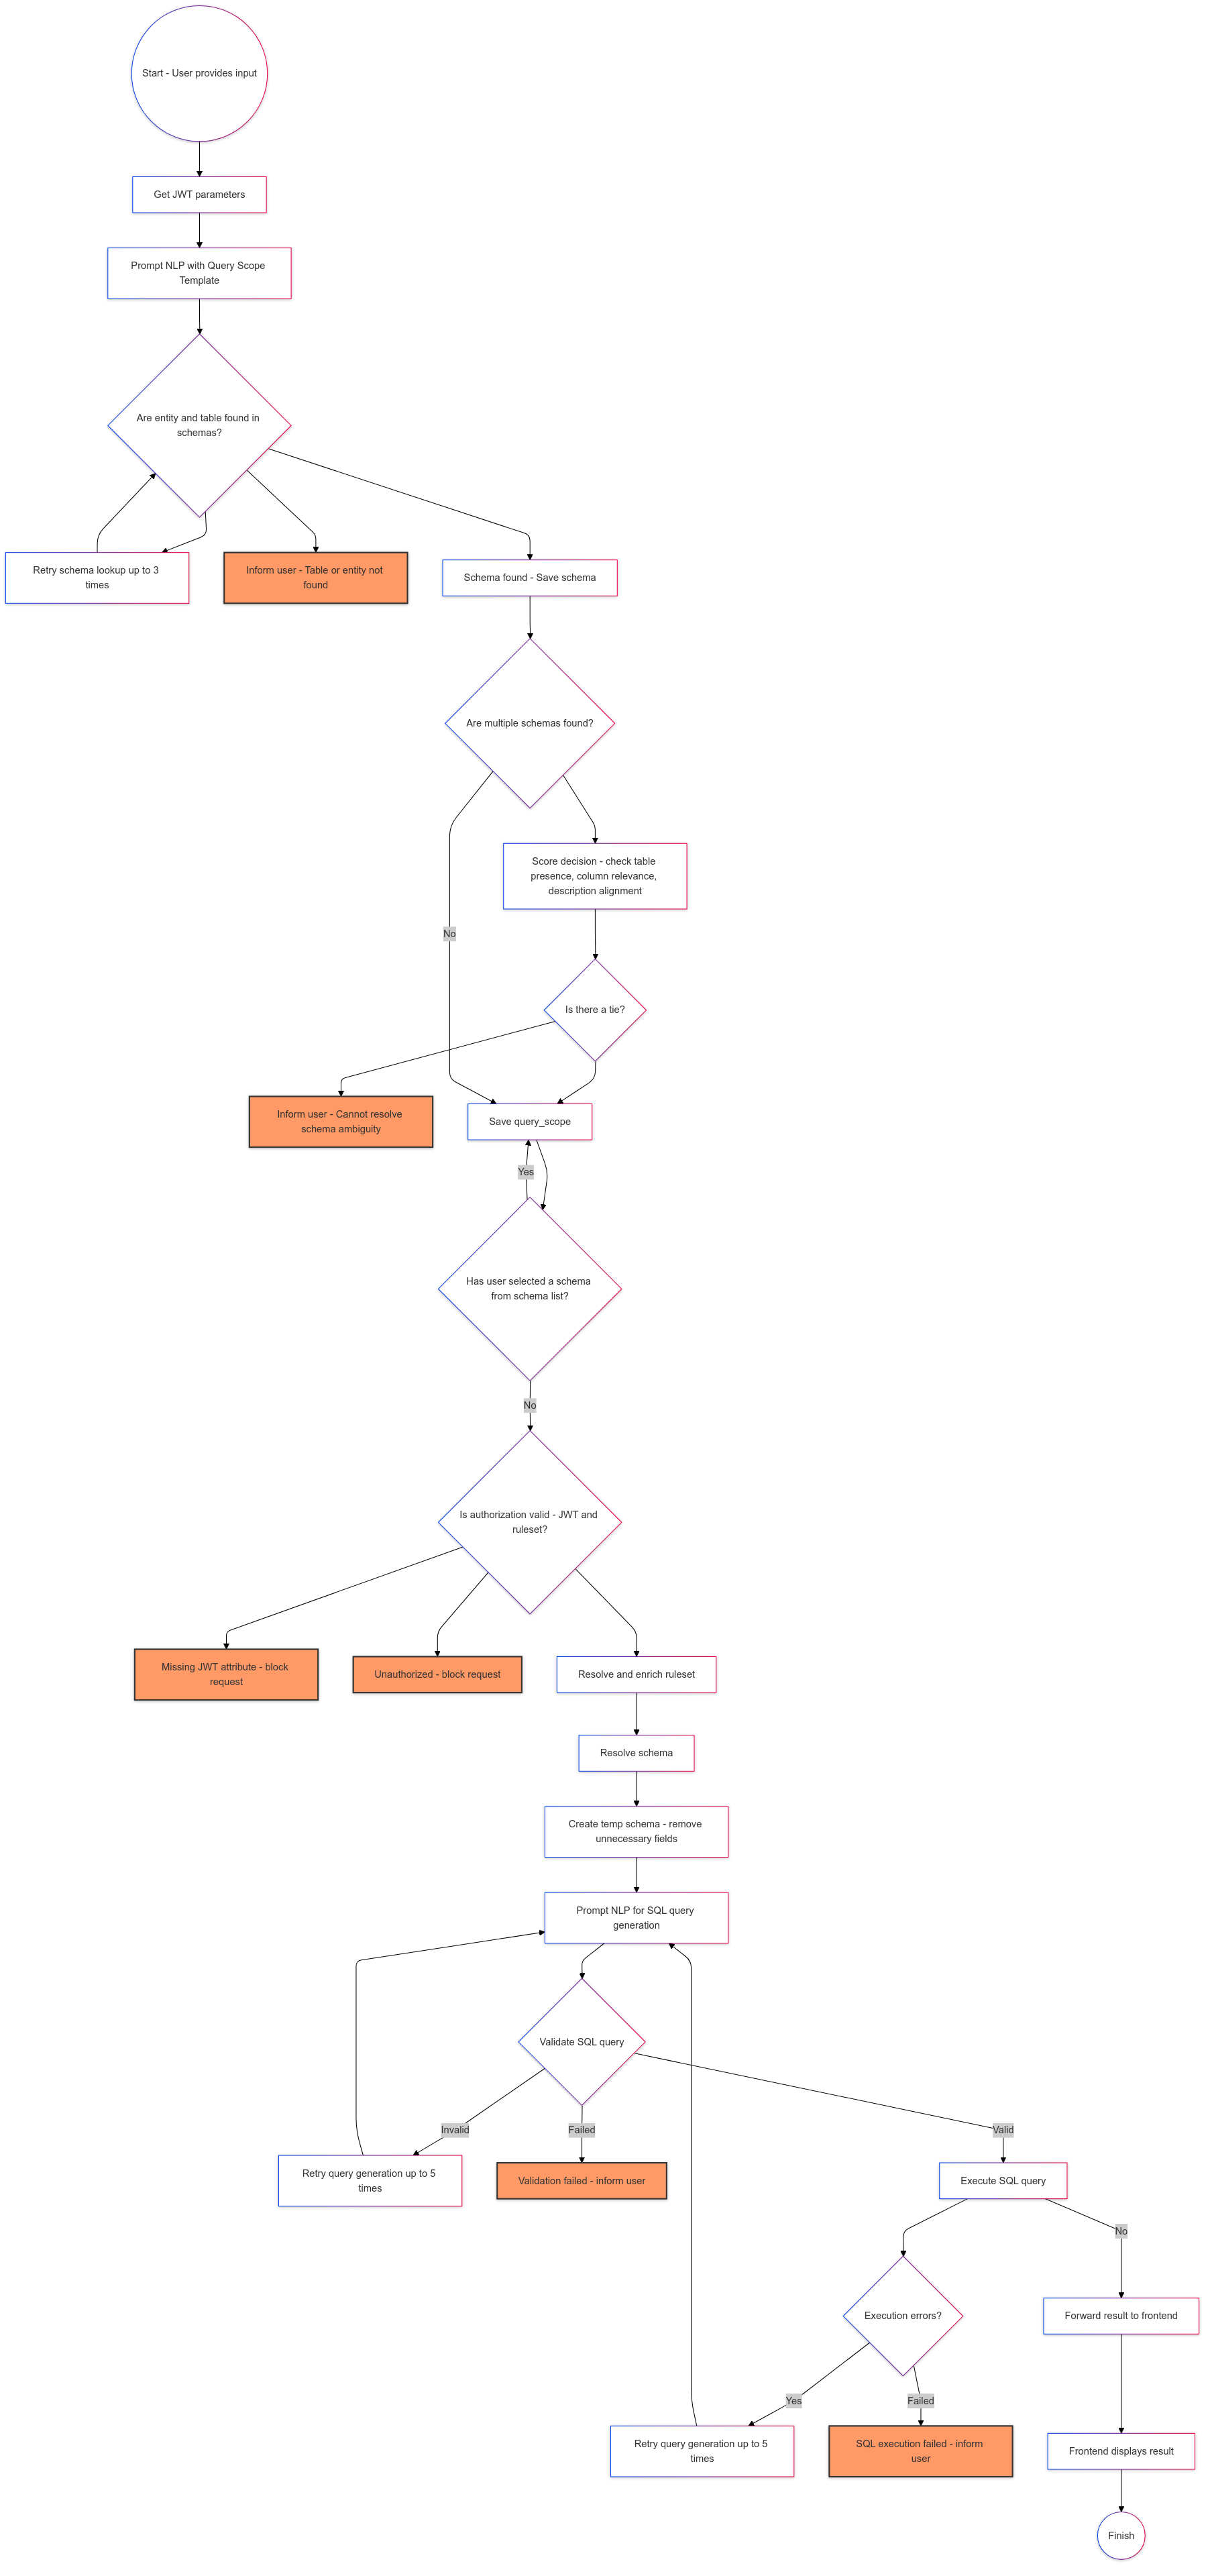

## Possible Use Cases for the Project

SQLExecutor bridges the gap between natural language and SQL, enabling non-technical users to query databases effortlessly. It ensures secure and authorized access through user-defined **rulesets** while remaining extensible across platforms. Key use cases include:

1. **Chatbot Integration**: Enhance chatbots to handle database queries via natural language.
2. **Dynamic API for Data Retrieval**: Simplify on-demand database queries with schemas and rulesets, eliminating the need for custom SQL.
3. **Accessible for Non-Technical Users**: Empower users to query databases without SQL expertise, making data accessible to everyone.